In [85]:
# file: mlb_lifetime_datafetch.ipynb
# poc: mlr4, mlrosewin@gmail.com
# created: may 2022
# last modified: may 2022

# Visualizing the Paths to Greatness of MLB's Active Strikeout Leaders

### Get lifetime data for a specified mlb player

From wikipedia:
Statcast is a high-speed, high-accuracy, automated tool developed to analyze player movements and athletic abilities in Major League Baseball (MLB).[1] Statcast was introduced to all thirty MLB stadiums in 2015. The Statcast brand is also licensed to ESPN, which uses it to brand alternate statistical simulcasts of the network's games on ESPN2 and ESPN+.

Python library reference: https://github.com/jldbc/pybaseball

## Get statcast pitch-by-pitch for 1 pitcher

https://github.com/jldbc/pybaseball

### Imports

In [31]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher

import time
import datetime

### Get player IDs

In [2]:
#playerid_lookup('scherzer', 'max') # key_mlbam, 453286
#playerid_lookup('verlander', 'justin') # key_mlbam, 434378
#playerid_lookup('greinke', 'zack') # 425844
#playerid_lookup('kershaw', 'clayton') # key_mlbam, 477132

id_scherzer =  453286
id_verlander = 434378
id_greinke = 425844
id_kershaw = 477132

### Get statcast pitch-by-pitch data

In [16]:
def clean_statcast_dataframe(df):
    '''
    '''
    df['game_date'] = pd.to_datetime(df['game_date'])
    df = df.sort_values(by='game_date')
    df = df.reset_index(drop=True)
    
    return df

In [17]:
def get_statcast_pitchbypitch(start, end, id_in):
        '''
        '''
        #df = statcast_pitcher('2000-01-01', '2023-01-01', 477132)
        df = statcast_pitcher(start, end, id_in)
        
        df = clean_statcast_dataframe(df)
        
        print(df.shape)
        print(df.columns)
        display(df.head())
        
        return df

In [18]:
# set unreasonably large date range to get all data that exists
start = '1990-01-01'
end = '2023-01-01'

#df_scherzer = get_statcast_pitchbypitch(start, end, id_scherzer)
#df_verlander = get_statcast_pitchbypitch(start, end, id_verlander)
#df_greinke = get_statcast_pitchbypitch(start, end, id_greinke)
#df_kershaw = get_statcast_pitchbypitch(start, end, id_kershaw)

In [19]:
#df_see = df_scherzer.copy() # (46050, 92)
#df_see = df_verlander.copy() # (54643, 92)
#df_see = df_greinke.copy() # (53360, 92)
#df_see = df_kershaw.copy() # (42825, 92)

#print(df_see.shape)
#display(df_see.head())
#display(df_see.tail())

In [27]:
df_scherzer = clean_statcast_dataframe(df_scherzer)
df_verlander = clean_statcast_dataframe(df_verlander)
df_greinke = clean_statcast_dataframe(df_greinke)
df_kershaw = clean_statcast_dataframe(df_kershaw)

### Save data as csv for later use

Attach timestamp to csv for future reference (i.e., when data was fetched from statcast)

In [33]:
timestamp = str(round(time.time()))
print(timestamp)
#print(datetime.fromtimestamp(int(timestamp)))

1651425964


In [35]:
df_scherzer.to_csv('data_scherzer_allpitches_' + timestamp + '.csv', index=False)
df_verlander.to_csv('data_verlander_allpitches_' + timestamp + '.csv', index=False)
df_greinke.to_csv('data_greinke_allpitches_' + timestamp + '.csv',index=False)
df_kershaw.to_csv('data_kershaw_allpitches_' + timestamp + '.csv',index=False)

### Filter datasets for strikeout events

In [36]:
df_kershaw['events'].value_counts()

field_out                     4657
strikeout                     3180
single                        1546
walk                           707
double                         429
home_run                       245
force_out                      212
grounded_into_double_play      202
field_error                    102
sac_bunt                       100
hit_by_pitch                    48
triple                          39
sac_fly                         36
intent_walk                     29
double_play                     29
fielders_choice_out             19
fielders_choice                 19
caught_stealing_2b               6
catcher_interf                   5
strikeout_double_play            2
sac_bunt_double_play             1
pickoff_caught_stealing_3b       1
caught_stealing_3b               1
caught_stealing_home             1
Name: events, dtype: int64

In [38]:
def filter_event_type(df, game_type, event):
    '''
    df: pandas dataframe
    game_type: string from 'game_type' field of statcast data
    event: string encoding from 'events' field of statcast data
    '''
    df = df[df['game_type'] == game_type] # 'R' is regular season
    df = df[df['events'] == event]
    df = df.sort_values(by='game_date')
    df = df.reset_index(drop=True)
    
    return df

In [51]:
df_scherzer_so = filter_event_type(df_scherzer, 'R', 'strikeout')
df_verlander_so = filter_event_type(df_verlander, 'R', 'strikeout')
df_greinke_so = filter_event_type(df_greinke, 'R', 'strikeout')
df_kershaw_so = filter_event_type(df_kershaw, 'R', 'strikeout')

print(df_scherzer.shape, df_scherzer_so.shape)
print(df_verlander.shape, df_verlander_so.shape)
print(df_greinke.shape, df_greinke_so.shape)
print(df_kershaw.shape, df_kershaw_so.shape)

(46050, 93) (3038, 93)
(54643, 92) (3027, 92)
(53360, 92) (2795, 92)
(42825, 92) (2698, 92)


### Aggregate by game

In [67]:
def aggregate_dataframe(df_in, aggregation):
    '''
    '''
    df_in['cnt'] = 1 # for aggregation
    df = df_in[['game_date', 'cnt']]
    df.index = df['game_date']
    df = df[['cnt']]
    df = df.resample('D').sum()
    df = df[df['cnt'] > 0] # filter out dates with no strikeout events
    df = df.reset_index() 
    df = df.reset_index() # create game count feature for time axis of vizes
    df.columns = ['game_cnt', 'game_date', 'cnt']
    df['game_cnt'] = df['game_cnt'] + 1
    df['so_cumsum'] = np.cumsum(df['cnt'])
    
    return df

In [69]:
df_scherzer_so_D = aggregate_dataframe(df_scherzer_so, 'D')
df_verlander_so_D = aggregate_dataframe(df_verlander_so, 'D')
df_greinke_so_D = aggregate_dataframe(df_greinke_so, 'D')
df_kershaw_so_D = aggregate_dataframe(df_kershaw_so, 'D')

print(df_scherzer_so_D.shape, df_verlander_so_D.shape, df_greinke_so_D.shape, df_kershaw_so_D.shape)
df_kershaw_so_D.tail()

(408, 4) (454, 4) (521, 4) (382, 4)


,game_cnt,game_date,cnt,so_cumsum
377,378,2021-10-01,1,2668
378,379,2022-04-13,13,2681
379,380,2022-04-18,7,2688
380,381,2022-04-24,3,2691
381,382,2022-04-30,7,2698


### Viz strike out trajectory by game number

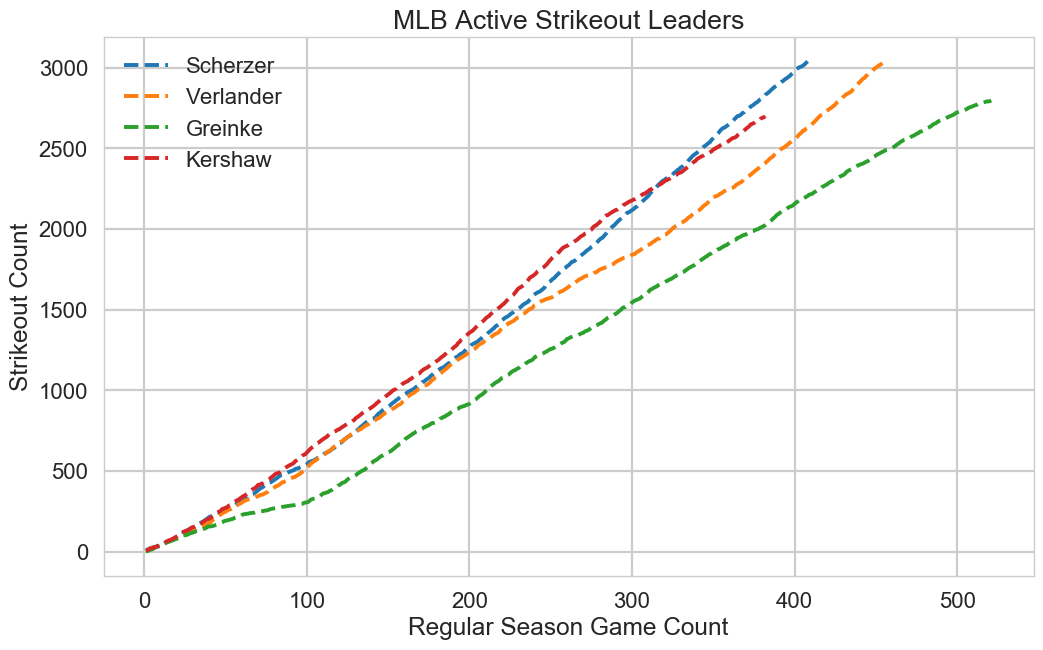

In [84]:
plt.figure(figsize=(12,7))
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.plot(df_scherzer_so_D['game_cnt'], df_scherzer_so_D['so_cumsum'],'--', label='Scherzer')
plt.plot(df_verlander_so_D['game_cnt'], df_verlander_so_D['so_cumsum'],'--', label='Verlander')
plt.plot(df_greinke_so_D['game_cnt'], df_greinke_so_D['so_cumsum'],'--', label='Greinke')
plt.plot(df_kershaw_so_D['game_cnt'], df_kershaw_so_D['so_cumsum'],'--', label='Kershaw')

plt.xlabel('Regular Season Game Count')
plt.ylabel('Strikeout Count')
plt.title('MLB Active Strikeout Leaders')

plt.legend();

plt.savefig('./active_strikeout_leaders_' + timestamp + '.jpg')

Conclusions include that Kershaw's strike rate per game was best until late in his career where Kershaw crossed under Scherzer. Greinke and Verlander are on slower trajectories per game but have pitched a greater number of games than Kershaw.

In [90]:
#df_kershaw_so_D.head(2)

In [89]:
#plt.figure()
#sns.displot(df_verlander_so_D, x='cnt', kind='kde', fill=True)
#sns.displot(df_kershaw_so_D, x='cnt', kind='kde', fill=True)